## Glyph error analysis

The `GlyphErrorBenchmark.cpp` creates a number of different rendered glyph textures into `src/rendered_glyph_textures` with different parameters (different code points, scales, original sizes etc.)

In this notebook I categorize these images and calculate the errors in each of them to figure out which method performs the best

In [118]:
# libraries
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from PIL import Image
from PIL import ImageOps

In [111]:
# type definitions
class GlyphType(Enum):
    Original = 0
    Bitmap = 1
    SdfFromBitmap = 2
    SdfFromVector = 3
    Msdf = 4
    MsdfOriginal = 5

class Glyph:
    def __init__(self, glyphType, code_point, original_size, scale, img):
        self.glyphType = glyphType
        self.code_point = code_point
        self.original_size = original_size
        self.scale = scale
        self.img = img
        self.error = None

    def __str__(self):
        return self.glyphType.name + ' ' + self.code_point + ' ' + str(self.original_size) + ' ' + str(self.scale)

    def isComparable(self, other):
        return self.scale == other.scale and self.original_size == other.original_size and self.code_point == other.code_point

In [147]:
# load and filter all the glyphs
directory = '../src/rendered_glyph_textures'

truth_glyphs = []
glyphs = []

for filename in os.listdir(directory):
    if filename.endswith('.png'):
        info = filename.split('_')
        glyph_type = GlyphType(int(info[0][0]))
        code_point = info[1]
        original_size = int(info[2])
        scale = float(info[3])
        img = Image.open(os.path.join(directory, filename)).convert('L')
        img.load()
        
        print('Found glyph: ' + str(glyph_type) + ' ' + str(code_point) + ' ' + str(original_size) + ' ' + str(scale) + ' image size: ' + str(img.size))

        if glyph_type == GlyphType.Original:
            truth_glyphs.append(Glyph(glyph_type, code_point, original_size, scale, img))
        else:
            glyphs.append(Glyph(glyph_type, code_point, original_size, scale, img))
print()
print('\033[96m' + 'Number of glyphs: ' + str(len(glyphs)))
print('\033[96m' + 'Number of glyph types: ' + str(len(set([g.glyphType for g in glyphs]))))
print('\033[96m' + 'Number of truth glyphs: ' + str(len(truth_glyphs)))

Found glyph: GlyphType.Original G 80 10.0 image size: (467, 586)
Found glyph: GlyphType.Original G 80 7.0 image size: (326, 409)
Found glyph: GlyphType.Bitmap G 80 10.0 image size: (457, 589)
Found glyph: GlyphType.Bitmap G 80 7.0 image size: (320, 409)
Found glyph: GlyphType.SdfFromBitmap G 80 10.0 image size: (467, 584)
Found glyph: GlyphType.SdfFromBitmap G 80 7.0 image size: (326, 409)
Found glyph: GlyphType.SdfFromVector G 80 10.0 image size: (466, 585)
Found glyph: GlyphType.SdfFromVector G 80 7.0 image size: (326, 409)
Found glyph: GlyphType.Msdf G 80 10.0 image size: (466, 585)
Found glyph: GlyphType.Msdf G 80 7.0 image size: (326, 409)
Found glyph: GlyphType.MsdfOriginal G 80 10.0 image size: (461, 578)
Found glyph: GlyphType.MsdfOriginal G 80 7.0 image size: (323, 405)

Number of glyphs: 10
Number of glyph types: 5
Number of truth glyphs: 2


In [150]:
# a and b are tuples of (r, g, b, a)
def errorFunction(a, b):
    return abs(a - b)

def calculateGlyphError(truth, glyph):
    if not truth.isComparable(glyph):
        raise Exception('Glyphs are not comparable: ' + str(truth) + ' ' + str(glyph))
    
    if truth.img.size != glyph.img.size:
        raise Exception('Glyphs have different sizes: ' + str(truth.img.size) + ' ' + str(glyph.img.size))

    # calculate error pixel by pixel
    error = 0
    for y in range(0, truth.img.height):
        for x in range(0, truth.img.width):
            truth_pixel = truth.img.getpixel((x, y))
            glyph_pixel = glyph.img.getpixel((x, y))
            error += errorFunction(truth_pixel, glyph_pixel)

    # normalize error
    error = error / (truth.img.width * truth.img.height)
    return error;

In [151]:
def findTruthForGlyph(glyph):
    for truth in truth_glyphs:
        if truth.isComparable(glyph):
            return truth
    return None

# rendered glyphs might have different sizes so we want to 
# add some zero pixels so they are the same size as the truth
# we need to be careful to keep them in the center
def resizeGlyph(glyph_image, new_width, new_height):
    delta_x = new_width - glyph_image.size[0]
    delta_y = new_height - glyph_image.size[1]

    # crop if needed
    if delta_x < 0:
        x_start = abs(delta_x) // 2
        glyph_image = glyph_image.crop((x_start, 0, new_width + 1, glyph_image.size[1]))
    if delta_y < 0:
        y_start = abs(delta_y) // 2
        glyph_image = glyph_image.crop((0, y_start, glyph_image.size[0], new_height + 1))

    # pad if needed
    if delta_x > 0:
        padding_x = delta_x // 2
        ob1 = delta_x % 2
        glyph_image = ImageOps.expand(glyph_image, (padding_x + ob1, 0, padding_x, 0))
    if delta_y > 0:
        padding_y = delta_y // 2
        ob1 = delta_y % 2
        glyph_image = ImageOps.expand(glyph_image, (0, padding_y + ob1, 0, padding_y))
    
    return glyph_image

# calculate all the glyph errors
for glyph in glyphs:
    truth = findTruthForGlyph(glyph)
    glyph.img = resizeGlyph(glyph.img, truth.img.size[0], truth.img.size[1])
    error = calculateGlyphError(truth, glyph)
    glyph.error = error

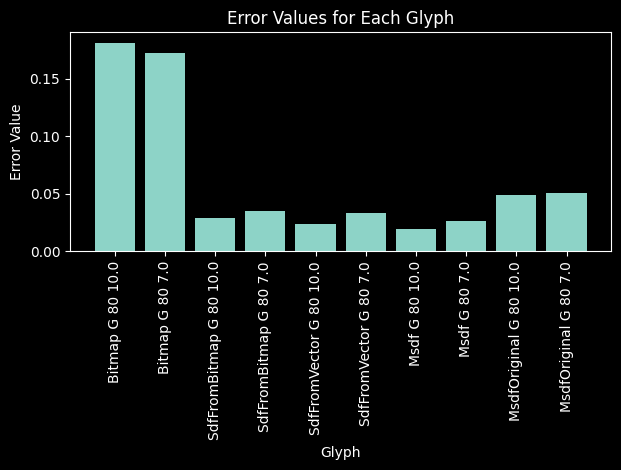

In [115]:
errors = [glyph.error for glyph in glyphs]

plt.bar([str(glyph) for glyph in glyphs], errors)

plt.title('Error Values for Each Glyph')
plt.xlabel('Glyph')
plt.ylabel('Error Value')
plt.xticks(rotation=90)

# show the plot
plt.tight_layout()
plt.show()

In [184]:
def showGlyphDiff(glyph):
    glyph_img = glyph.img
    truth_img = findTruthForGlyph(glyph).img

    truth_img = ImageOps.colorize(truth_img, black='black', white='red')

    # convert glyph_img to RGBA
    glyph_img_rgba = np.array(glyph_img.convert('RGBA'))
    truth_img_rgba = np.array(truth_img.convert('RGBA'))

    # set alpha channel to 0 where pixel value is black 
    glyph_img_rgba[glyph_img_rgba[:, :, 0] == 0, 3] = 0
    truth_img_rgba[truth_img_rgba[:, :, 0] == 0, 3] = 0

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    background_color = '#020f24'
    ax.set_facecolor(background_color)
    fig.patch.set_facecolor(background_color)
    ax.spines['bottom'].set_color(background_color)
    ax.spines['top'].set_color(background_color)
    ax.spines['right'].set_color(background_color)
    ax.spines['left'].set_color(background_color)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(truth_img_rgba)
    ax.imshow(glyph_img_rgba, alpha=0.8)

    # show the plot
    plt.tight_layout()
    plt.show()